# PIRIS + Bayesian Optimization
**Bayesian Optimization for hyperparameter tunning in PIRIS**


# Librerias y Constantes

In [29]:
#Importamos ls librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import kmeans_plusplus
import pandas as pd
import tensorflow as tf
import optuna
from optuna.samplers import GPSampler

In [30]:
# Parametros de creación de la muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6

# Parametros del potencial L-J
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 * kj_mol_to_ev #Fondo del pozo del Oxigeno (eV/atom)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 *kj_mol_to_ev #Fondo del pozo Niquel (ev/atom)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 *kj_mol_to_ev #Fondo del pozo Zinc (ev/atom)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 

# Parametros potencial coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
q_Ni = 2 #(carga del electron e)
q_O = -0.86 #(carga del electron e)
q_Zn = 0.86 #(carga del electron e)

# Radios de corte de intereacción basados en el potencial L-J
r_cutoffO_Ni = 2.5*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 2.5*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 2.5*SigmaNi #Radio maximo de interacción Ni-Ni(A)

In [31]:
# Casteamos a tf los parametros
SigmaO_Ni = tf.cast(SigmaO_Ni, tf.float32)
EpsilonO_Ni = tf.cast(EpsilonO_Ni, tf.float32)
SigmaZn_Ni = tf.cast(SigmaZn_Ni, tf.float32)
EpsilonZn_Ni = tf.cast(EpsilonZn_Ni, tf.float32)
SigmaNi_Ni = tf.cast(SigmaNi, tf.float32)
EpsilonNi_Ni = tf.cast(EpsilonNi, tf.float32)
k_e = tf.cast(k_e,tf.float32)
q_Ni = tf.cast(q_Ni,tf.float32)
q_O = tf.cast(q_O,tf.float32)
q_Zn = tf.cast(q_Zn,tf.float32)
r_cutoffO_Ni = tf.cast(r_cutoffO_Ni, tf.float32)
r_cutoffZn_Ni = tf.cast(r_cutoffZn_Ni, tf.float32)
r_cutoffNi_Ni = tf.cast(r_cutoffNi_Ni, tf.float32)

# Creación de la muestra ZnO en forma Grafeno

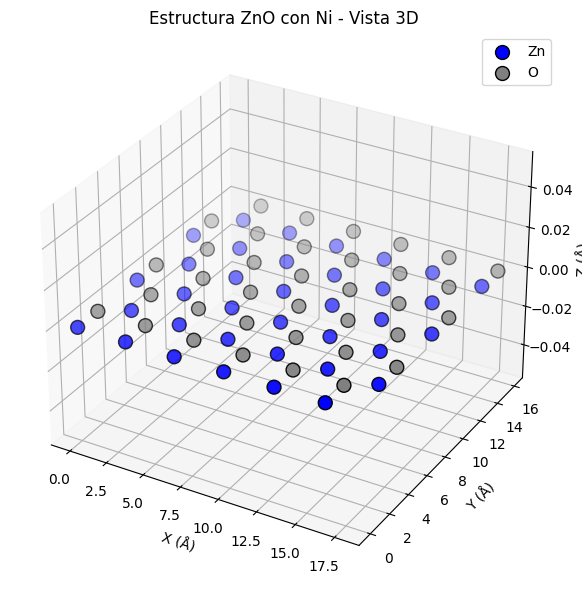

In [32]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)



num_atoms = len(positions)
positions = np.array(positions)
elements = np.array(elements)

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

**Para el k-means++, necesitamos unos limites alrededor de la superficie**

In [33]:
def calcular_limites_superficie(posiciones, padding=2.0):
    """
    Calcula los límites en (x,y) de una estructura atómica, añadiendo un margen.

    Args:
        posiciones (np.ndarray): Un array de forma (N, 3) con las coordenadas (x,y,z)
                                 de los átomos de la superficie.
        padding (float): Un margen en Angstroms que se añadirá en cada dirección
                         (min y max) a los límites de la estructura.

    Returns:
        tuple: Una tupla conteniendo los límites en X y Y. 
               Formato: ((x_min, x_max), (y_min, y_max))
    """
    if posiciones.ndim != 2 or posiciones.shape[1] < 2:
        raise ValueError("El array de posiciones debe tener forma (N, 2) o (N, 3).")
        
    # Extraer las coordenadas x e y
    x_coords = posiciones[:, 0]
    y_coords = posiciones[:, 1]
    
    # Encontrar los valores mínimos y máximos
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    # Aplicar el padding
    limites_x = (x_min - padding, x_max + padding)
    limites_y = (y_min - padding, y_max + padding)
    
    print(f"Límites de la estructura calculados:")
    print(f"  - Rango X (con padding): ({limites_x[0]:.2f}, {limites_x[1]:.2f})")
    print(f"  - Rango Y (con padding): ({limites_y[0]:.2f}, {limites_y[1]:.2f})")
    
    return limites_x, limites_y

# Creación de los iones que se van a adsorber

**Vamos a tratar la altura Z como un hiperparametro a optmizar**

**Definimos la creacion de los iones como una función, para llamarla dentro del loop de BO** 

In [34]:
def generate_xy(malla, k_simulaciones, num_ni_por_simulacion, random_seed=42):
    """
    Selecciona 'k_simulaciones' conjuntos de 'num_ni_por_simulacion' posiciones (x,y)
    cada uno.

    Args:
        malla (np.ndarray): Array de posiciones candidatas (N, 2).
        k_simulaciones (int): Número de simulaciones/configuraciones a generar.
        num_ni_por_simulacion (int): Número de iones en cada simulación.
        random_seed (int): Semilla para reproducibilidad.

    Returns:
        list: Una lista de 'k_simulaciones' arrays. Cada array tiene forma 
              (num_ni_por_simulacion, 2) y representa una configuración inicial.
    """
    total_puntos_a_seleccionar = k_simulaciones * num_ni_por_simulacion
    
    if total_puntos_a_seleccionar > malla.shape[0]:
        raise ValueError("El número total de puntos a seleccionar (k * num_ni) excede el tamaño de la malla.")

    # 1. Usar k-means++ para seleccionar un gran conjunto de puntos bien espaciados
    puntos_seleccionados, _ = kmeans_plusplus(
        malla, 
        n_clusters=total_puntos_a_seleccionar, 
        random_state=random_seed
    )
    
    print(f"Se han seleccionado {total_puntos_a_seleccionar} puntos en total con k-means++.")
    
    # 2. Agrupar estos puntos en 'k_simulaciones' configuraciones
    configuraciones = np.array_split(puntos_seleccionados, k_simulaciones)
    
    print(f"Se han agrupado en {len(configuraciones)} configuraciones de {num_ni_por_simulacion} iones cada una.")
    
    return configuraciones
        
def build_ions(xy_positions,z):
    """Recibe posiciones xy pre definidas y la altura z para combinarlas y generar los iones
    a adsorber
    args: 
        xy_positions:array con un conjunto de posiciones xy preseleccionadas.
        z: float de altura optimizable por optuna
    returns:
        np.ndarray: Array de forma (num_ni, 3) con las posiciones completas (x,y,z)"""
    #Tomamos la cantidad de iones del array de coordenaads xy
    num_ni = xy_positions.shape[0]
    # Crea una columna de 'z' con el mismo valor para todos los iones
    z_column = np.full((num_ni, 1), z)
    
    # Concatena las posiciones (x,y) con la columna z
    ion_positions = np.hstack([xy_positions, z_column])
    
    return ion_positions


**Tambien definimos una funcion para el muestreo de posibles coordenadas xy usando k-means++**

In [35]:
def xy_candidate_selection(limites_x, limites_y, puntos_por_eje):
    """
    Construye una malla 2D de posibles posiciones iniciales dados unos límites.

    Args:
        limites_x (tuple): Una tupla (x_min, x_max).
        limites_y (tuple): Una tupla (y_min, y_max).
        puntos_por_eje (int): Número de puntos a generar por cada eje.

    Returns:
        np.ndarray: Un array de forma (N, 2) con las coordenadas (x, y) de la malla.
    """
    # Generar los puntos en cada eje usando los límites calculados
    x_coords = np.linspace(limites_x[0], limites_x[1], puntos_por_eje)
    y_coords = np.linspace(limites_y[0], limites_y[1], puntos_por_eje)
    
    # Crear la malla usando meshgrid
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    # Aplanar y combinar en un array de coordenadas (N, 2)
    malla = np.vstack([xx.ravel(), yy.ravel()]).T
    
    print(f"Malla de {malla.shape[0]} posiciones candidatas creada sobre los límites definidos.")
    return malla

# Definición del costo para entrenamiento y evaluación.

**Costo de entrenamiento**

In [36]:
# Lennard-Jones potential function
@tf.function
def physical_potential(r, epsilon, sigma, q_j):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon # Sumamos epsilon para dejar el fondo del pozo en 0
    coulomb = k_e * q_Ni * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Funcion para calcular el potencial de informacion, individual y cruzado
@tf.function
def calculate_cross_information_potential(points1, points2, sigma):
    """
    Calcula el Potencial de Información Cruzado (V) entre dos conjuntos de puntos.
    Si points1 y points2 son el mismo, calcula el Potencial de Información (IP).
    """
    diff = tf.expand_dims(points1, 1) - tf.expand_dims(points2, 0)
    sq_dists = tf.reduce_sum(tf.square(diff), axis=-1)
    kernel_matrix = tf.exp(-sq_dists / (2.0 * sigma**2))
    return tf.reduce_mean(kernel_matrix)
    
# Función de costo para el entrenamiento del modelo
@tf.function
def get_training_loss(positions, elements, ni_positions, pri_weight, lambda_pri, sigma_pri):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando un potencial fisico y una regularizacion por PRI.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor con etiquetas de tipo de atomo (num_superficie,)
        pri_weight,lambda_pri,sgma_pri: hiperparametros escalares que modelan el peso de la regulaización
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
    """
    
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ni_exp = tf.expand_dims(ni_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ni_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)
     
    # Casteamos las etiquetas para que tengan la forma de r
     elements_exp = tf.reshape(elements, (-1, 1))  # (num_atoms, 1)

    # Creamos una mascara para etiquetar las interacciones
     is_O = tf.equal(elements_exp, "O")
     is_Zn = tf.equal(elements_exp, "Zn")


    # Calculamos la energía aplicando cortes de distancia de interacción
     energy_O = tf.where(r < r_cutoffO_Ni,
                        physical_potential(r, EpsilonO_Ni, SigmaO_Ni,q_O),
                        tf.zeros_like(r))
     energy_Zn = tf.where(r < r_cutoffZn_Ni,
                         physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn),
                         tf.zeros_like(r))
    # Filtramos el valor de la energía dependiendo de la etiqueta
     atoms_energy_matrix = tf.where(is_O, energy_O,
                            tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)

    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Calculamos la energia promedio por ion considerando que no todos interactuan con la misma
    # cantidad de atomos.
    # Definimos mascaras para contar las interacciones validas
     mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
     mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
     interaction_mask_atoms = tf.maximum(mask_O, mask_Zn)  # shape: (num_atoms, num_ions)
    # Número de interacciones válidas por ion
     count_per_ion = tf.reduce_sum(interaction_mask_atoms, axis=0)  # shape: (num_ions,)
     count_per_ion_safe = tf.where(count_per_ion == 0, 1.0, count_per_ion)  # evitar división por cero
    # Energia promedio de cada ion
     mean_energy_per_ion = energy_per_ion / count_per_ion_safe  # shape: (num_ions,)
    #---------


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True
     mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                             physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni),
                             tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    
    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Número de interacciones válidas por ion
     count_per_ion_ion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32), axis=0)  # (num_ions,)
     count_per_ion_ion_safe = tf.where(count_per_ion_ion == 0, 1.0, count_per_ion_ion)
    # Energias promedio ion_ion
     mean_ion_ion_energy_per_ion = ion_ion_energy_per_ion / count_per_ion_ion_safe  # (num_ions,)
    #---------------
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy

    #--------------------REGULARIZACIÓN CON PRI----------------------
    # Analogía: positions -> majority class | ion_positions -> undersampled majority class 

     epsilon_log = 1e-10  # Para estabilidad numérica en el logaritmo

    # Calcular potenciales de información
     ip_ions = calculate_cross_information_potential(ni_positions, ni_positions, sigma_pri)
     ip_surface = calculate_cross_information_potential(positions, positions, sigma_pri) # Es constante, pero se calcula aquí por simplicidad
     cip_ions_surface = calculate_cross_information_potential(ni_positions, positions, sigma_pri)
    # Calcular entropías cuadráticas (H2 = -log(V))
     H2_ions = -tf.math.log(ip_ions + epsilon_log)
     H2_surface = -tf.math.log(ip_surface + epsilon_log)
     H2_cross = -tf.math.log(cip_ions_surface + epsilon_log)

    # Calcular Divergencia de Cauchy-Schwarz (D_cs= 2H2(ion,surface)- H2(ion)- H2(surface)) - Eq. 4 del paper
     D_cs = 2 * H2_cross - H2_ions - H2_surface
    # Calcular costo PRI - Eq. 7 del paper
    # J(X_hat) = H2(X_hat) + lambda * D_cs(X_hat, X)
     pri_cost = (1- lambda_pri)*H2_ions + 2*lambda_pri * D_cs

    #------------COMBINAR Y RETORNAR----------------

     total_loss = energy_total + pri_weight * pri_cost
    
     return  total_loss, energy_total_per_ion# si no es necesario, solo retorna la energia con minimo en 0

**Costo de evaluación**

In [37]:
@tf.function
def calculate_final_system_energy(positions, elements, ni_positions):
    """
    Calcula la energía del sistema sin PRI y corrige el shift potencial de la energía
    """
    pos_exp = tf.expand_dims(positions, axis=1)
    ni_exp = tf.expand_dims(ni_positions, axis=0)
    r = tf.norm(pos_exp - ni_exp, axis=2)
    elements_exp = tf.reshape(elements, (-1, 1))
    is_O = tf.equal(elements_exp, "O")
    is_Zn = tf.equal(elements_exp, "Zn")
    
    energy_O = tf.where(r < r_cutoffO_Ni, physical_potential(r, EpsilonO_Ni, SigmaO_Ni, q_O), tf.zeros_like(r))
    energy_Zn = tf.where(r < r_cutoffZn_Ni, physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn), tf.zeros_like(r))
    atoms_energy_matrix = tf.where(is_O, energy_O, tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)

    diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)
    r_ion = tf.norm(diff_ion, axis=-1)
    eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)
    mask_offdiag = tf.logical_not(eye)
    mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)
    interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)
    valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))
    ion_energy_matrix = tf.where(interaction_mask_ions, physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni), tf.zeros_like(r_ion))
    ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)
    
    ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5
    physical_energy_total = tf.reduce_sum(energy_per_ion) + ion_ion_total_energy
    
    # --- Apply the final epsilon correction ---
    mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
    mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
    num_interactions_O = tf.reduce_sum(tf.cast(mask_O, tf.float32))
    num_interactions_Zn = tf.reduce_sum(tf.cast(mask_Zn, tf.float32))
    num_interactions_ionion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32))*0.5 #igual que en la energía, las interacciones se cuentan doble
    total_epsilon_shift = (
        num_interactions_O * EpsilonO_Ni +
        num_interactions_Zn * EpsilonZn_Ni +
        num_interactions_ionion * EpsilonNi_Ni
    )
    corrected_energy_total = physical_energy_total - total_epsilon_shift
    
    return corrected_energy_total, energy_per_ion + ion_ion_energy_per_ion

# Entrenamiento

**Convertir variables a tf**

In [38]:
#tensorflow data
sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)

**Definmos un exponential decay learning rate**

In [39]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** (epoch/5)

**Definimos clase para early stop**

In [40]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

# Bayesian Optimization

**Definimos la funcion objetivo de la optimización bayesiana**

In [41]:
def objective(trial):
    """
    Objective function for Optuna to minimize.
    It runs the PIRIS simulation for a given set of hyperparameters.
    """
    # --- 1. Suggest hyperparameters from the trial object ---
    # Z-height: range is based on physical constants
    z_min_bound = float(SigmaO_Ni.numpy())
    z_max_bound = float(8 * SigmaZn_Ni.numpy()) # A reasonable upper bound based on cutoff radius and PRI reach
    z_initial = trial.suggest_float("z", z_min_bound, z_max_bound)

    # PRI hyperparameters
    pri_weight_val = trial.suggest_float("pri_weight", 1.0, 10.0) #Up to 10 given the magnitude of H vs PRI loss
    lambda_pri_val = trial.suggest_float("lambda_pri", 0.0, 1.0)
    
    # Sigma_pri: search space follows the magnitude of z
    sigma_pri_val = trial.suggest_float("sigma_pri", 1.0, 8*SigmaZn_Ni.numpy(), log=True)# A reasonable range follows z distribution

    # Use the learning rate and decay rate suggested by the trial
    eta0 = trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True)
    decay_rate = trial.suggest_float("decay_rate", 0.90, 0.99)

    # --- 2. Setup the simulation for this trial ---
    # Create the initial ion positions with the suggested z
    initial_ni_positions = build_ions(xy_positions, z=z_initial)
    ion = tf.Variable(initial_ni_positions, dtype=tf.float32)

    # Cast hyperparameters to TensorFlow constants for this trial
    pri_weight = tf.constant(pri_weight_val, dtype=tf.float32)
    lambda_pri = tf.constant(lambda_pri_val, dtype=tf.float32)
    sigma_pri = tf.constant(sigma_pri_val, dtype=tf.float32)

    # --- 3. Run the training loop ---
    epochs = 200  # Reduced for faster optimization trials
    optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)

    for epoch in range(epochs):
        eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
        optimizer.learning_rate.assign(eta)
        
        with tf.GradientTape() as g:
            g.watch(ion)
            H_loss, _ = get_training_loss(sample_atoms, sample_elements, ion.value(), pri_weight, lambda_pri, sigma_pri)
        
        grad_ = g.gradient(H_loss, ion)
        
        # Check for NaN gradients which can happen with extreme hyperparameters
        if tf.reduce_any(tf.math.is_nan(grad_)):
            # If gradients are NaN, the trial is bad. Return a large value.
            return 1e6

        optimizer.apply_gradients(zip([grad_], [ion]))

    # --- 4. Calculate final energy and return it ---
    final_energy, _ = calculate_final_system_energy(sample_atoms, sample_elements, ion.value())
    
    return final_energy.numpy()

**Optimization loop**

In [42]:
#Definimos el box alrededor de la superficie para los candidatos a xy
limit_x,limit_y = calcular_limites_superficie(positions, padding=2.0)

#Definimos la malla de candidatos xy
puntos_por_eje = 50 #Número de puntos para tomar candidatos
malla = xy_candidate_selection(limit_x, limit_y, puntos_por_eje)

#Ejecutamos el algoritmo k-means++ para elegir los candidatos
k = 10 #Cantidad de simulaciones diferentes por probar 
num_ni = 1 #numero de iones a adsorber simultaneamente
configuraciones=generate_xy(malla, k, num_ni, random_seed=42)

Trials =[] #Hiperparametros optimizados en cada k-prueba

for i, xy_positions in enumerate(configuraciones):
    print("K_try: ",i)
    print("x,y for try ",i,": ",xy_positions)
    
    
    # Create a study object and specify the optimization direction and sampler.
    # We use GPSampler for Bayesian Optimization.
    study = optuna.create_study(direction='minimize', sampler=GPSampler(seed=10))
    
    # Start the optimization. Optuna will call the 'objective' function for n_trials.
    study.optimize(objective, n_trials=50)
    
    # --- Print the results ---
    #print("Number of finished trials: ", len(study.trials))
    #print("Best trial:")
    trial = study.best_trial
    
    #print("  Value (minimized energy): ", trial.value)
    #print("  Params: ")
    Trials.append(trial)
    
for i,trial in enumerate(Trials):
    print("-----Trial results summary-----")
    print("Trial number: ", i)
    print("Value (minimized energy): ", trial.value)
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

/tmp/ipykernel_36/1103785230.py:22: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(direction='minimize', sampler=GPSampler(seed=10))
[I 2025-07-31 14:50:46,839] A new study created in memory with name: no-name-72d90bb3-232a-4a85-9974-8d86fc89c3b1


Límites de la estructura calculados:
  - Rango X (con padding): (-2.00, 19.75)
  - Rango Y (con padding): (-2.00, 17.84)
Malla de 2500 posiciones candidatas creada sobre los límites definidos.
Se han seleccionado 10 puntos en total con k-means++.
Se han agrupado en 10 configuraciones de 1 iones cada una.
K_try:  0
x,y for try  0 :  [[2.43825686 4.88170408]]


[I 2025-07-31 14:50:50,750] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:50:52,842] Trial 1 finished with value: 13.420953750610352 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:50:54,921] Trial 2 finished with value: 17.155887603759766 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:50:57,005] Trial 3 finished wi

K_try:  1
x,y for try  1 :  [[13.533899    9.73937755]]


[I 2025-07-31 14:52:52,654] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:52:54,733] Trial 1 finished with value: -16.317468643188477 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -16.317468643188477.
[I 2025-07-31 14:52:56,832] Trial 2 finished with value: -11.508645057678223 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 1 with value: -16.317468643188477.
[I 2025-07-31

K_try:  2
x,y for try  2 :  [[13.533899   -1.19038776]]


[I 2025-07-31 14:54:49,909] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:54:52,013] Trial 1 finished with value: 12.38864803314209 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:54:54,093] Trial 2 finished with value: 13.043878555297852 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:54:56,191] Trial 3 finished wit

K_try:  3
x,y for try  3 :  [[-0.66852294 15.40666327]]


[I 2025-07-31 14:56:50,468] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:56:52,624] Trial 1 finished with value: -10.689859390258789 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -10.689859390258789.
[I 2025-07-31 14:56:54,718] Trial 2 finished with value: -14.253042221069336 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.253042221069336.
[I 2025-07-31

K_try:  4
x,y for try  4 :  [[ 5.54503666 12.57302041]]


[I 2025-07-31 14:58:49,563] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 14:58:51,675] Trial 1 finished with value: -14.174562454223633 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -14.174562454223633.
[I 2025-07-31 14:58:53,750] Trial 2 finished with value: -15.341428756713867 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -15.341428756713867.
[I 2025-07-31

K_try:  5
x,y for try  5 :  [[19.7474586   4.88170408]]


[I 2025-07-31 15:00:46,683] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:00:48,759] Trial 1 finished with value: 7.2320427894592285 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:00:50,860] Trial 2 finished with value: 15.001319885253906 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:00:52,963] Trial 3 finished wi

K_try:  6
x,y for try  6 :  [[13.09007331 17.8355    ]]


[I 2025-07-31 15:02:46,010] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:02:48,099] Trial 1 finished with value: -13.71330738067627 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -13.71330738067627.
[I 2025-07-31 15:02:50,181] Trial 2 finished with value: -14.857298851013184 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.857298851013184.
[I 2025-07-31 1

K_try:  7
x,y for try  7 :  [[9.98329351 3.66728571]]


[I 2025-07-31 15:04:43,096] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:04:45,164] Trial 1 finished with value: 19.433847427368164 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:04:47,236] Trial 2 finished with value: 22.853696823120117 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:04:49,308] Trial 3 finished wi

K_try:  8
x,y for try  8 :  [[ 1.1067798 -2.       ]]


[I 2025-07-31 15:06:41,617] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:06:43,729] Trial 1 finished with value: 14.697808265686035 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:06:45,817] Trial 2 finished with value: 19.168018341064453 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:06:47,903] Trial 3 finished wi

K_try:  9
x,y for try  9 :  [[16.19685311 17.02588776]]


[I 2025-07-31 15:08:40,514] Trial 0 finished with value: 0.0 and parameters: {'z': 21.9718982690712, 'pri_weight': 1.1867675442346135, 'lambda_pri': 0.6336482349262754, 'sigma_pri': 11.966497965350943, 'learning_rate': 0.022154169449531084, 'decay_rate': 0.9202316980977763}. Best is trial 0 with value: 0.0.
[I 2025-07-31 15:08:42,624] Trial 1 finished with value: -13.88391399383545 and parameters: {'z': 8.073836300973472, 'pri_weight': 7.8447764097906285, 'lambda_pri': 0.16911083656253545, 'sigma_pri': 1.3402095213482417, 'learning_rate': 0.07075637776590661, 'decay_rate': 0.9858054011575443}. Best is trial 1 with value: -13.88391399383545.
[I 2025-07-31 15:08:44,700] Trial 2 finished with value: -14.85886287689209 and parameters: {'z': 3.367721845898899, 'pri_weight': 5.60973037047199, 'lambda_pri': 0.8126209616521135, 'sigma_pri': 7.61699252471954, 'learning_rate': 0.08871477434617907, 'decay_rate': 0.926268846135357}. Best is trial 2 with value: -14.85886287689209.
[I 2025-07-31 15:

-----Trial results summary-----
Trial number:  0
Value (minimized energy):  -25.058883666992188
    z: 27.516000747680664
    pri_weight: 1.0
    lambda_pri: 0.9086617401426218
    sigma_pri: 3.68399845134562
    learning_rate: 0.49999999999999994
    decay_rate: 0.9472647144635419
-----Trial results summary-----
Trial number:  1
Value (minimized energy):  -25.15447998046875
    z: 3.2720000743865967
    pri_weight: 9.999999999999998
    lambda_pri: 0.7673545023427332
    sigma_pri: 23.364357888260333
    learning_rate: 0.49999999999999994
    decay_rate: 0.99
-----Trial results summary-----
Trial number:  2
Value (minimized energy):  0.0
    z: 21.9718982690712
    pri_weight: 1.1867675442346135
    lambda_pri: 0.6336482349262754
    sigma_pri: 11.966497965350943
    learning_rate: 0.022154169449531084
    decay_rate: 0.9202316980977763
-----Trial results summary-----
Trial number:  3
Value (minimized energy):  -21.3118896484375
    z: 3.2720000743865967
    pri_weight: 9.999999999999

**Visualizacion de los resultados de la optimización**

In [43]:
import pandas as pd

records =[]
for trial in Trials:
    record={"Energy":trial.value}
    record.update(trial.params)
    records.append(record)
data = pd.DataFrame(records)
print("Your data, ready for plotting:")
print(data)

Your data, ready for plotting:
      Energy          z  pri_weight  lambda_pri  sigma_pri  learning_rate  \
0 -25.058884  27.516001    1.000000    0.908662   3.683998       0.500000   
1 -25.154480   3.272000   10.000000    0.767355  23.364358       0.500000   
2   0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
3 -21.311890   3.272000   10.000000    0.000000  27.516001       0.292553   
4 -25.160404   3.272000    6.616240    0.000000  27.516001       0.500000   
5   0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
6 -25.160402   5.968498   10.000000    0.000000  27.516001       0.500000   
7   0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
8   0.000000  21.971898    1.186768    0.633648  11.966498       0.022154   
9 -23.345886   3.272000    1.000000    0.000000  27.516001       0.500000   

   decay_rate  
0    0.947265  
1    0.990000  
2    0.920232  
3    0.990000  
4    0.975829  
5    0.920232  
6    0.99

In [44]:
import plotly.express as px

# For better visualization, we can color the lines by the objective value
# It's good to have a column that is easy to interpret, like 'performance'
df_sorted = data.sort_values(by='Energy')

fig = px.parallel_coordinates(
    df_sorted,
    color="Energy",
    labels={col: col.replace('_', ' ').title() for col in data.columns},
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Parallel Coordinates of Best Hyperparameters"
)
fig.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

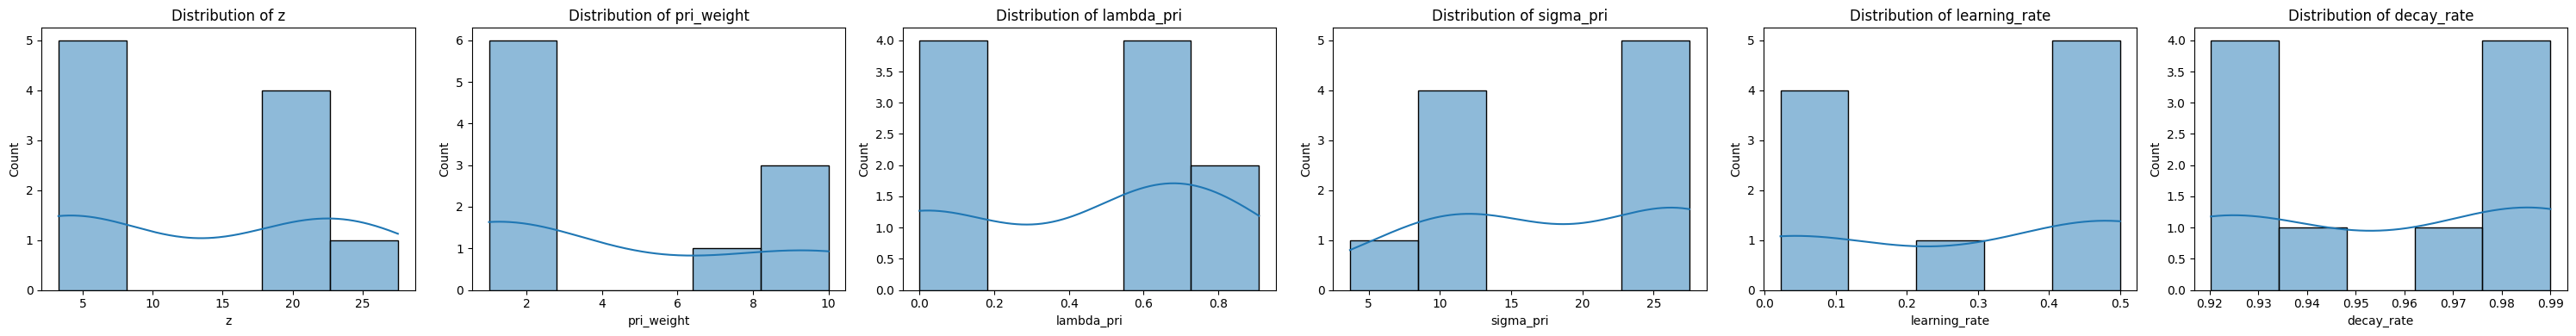

In [45]:
import seaborn as sns

# Identify categorical and numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.drop('Energy')
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Create plots for numerical parameters (Histograms/KDEs)
if len(numerical_cols) > 0:
    fig, axes = plt.subplots(1, len(numerical_cols), figsize=(5 * len(numerical_cols), 4))
    if len(numerical_cols) == 1: axes = [axes] # Ensure axes is iterable
    for ax, col in zip(axes, numerical_cols):
        sns.histplot(data, x=col, kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Create plots for categorical parameters (Count Plots)
if len(categorical_cols) > 0:
    fig, axes = plt.subplots(1, len(categorical_cols), figsize=(5 * len(categorical_cols), 4))
    if len(categorical_cols) == 1: axes = [axes] # Ensure axes is iterable
    for ax, col in zip(axes, categorical_cols):
        sns.countplot(data=df, x=col, ax=ax, order=df[col].value_counts().index)
        ax.set_title(f'Counts of {col}')
    plt.tight_layout()
    plt.show()

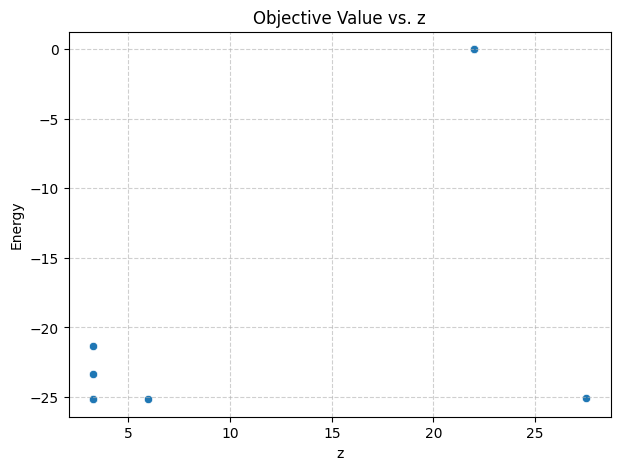

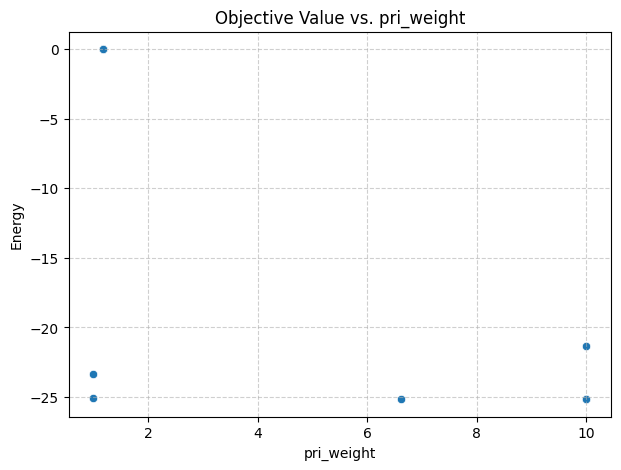

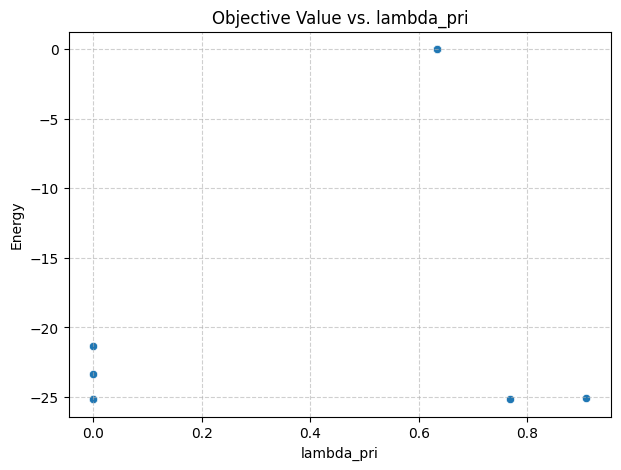

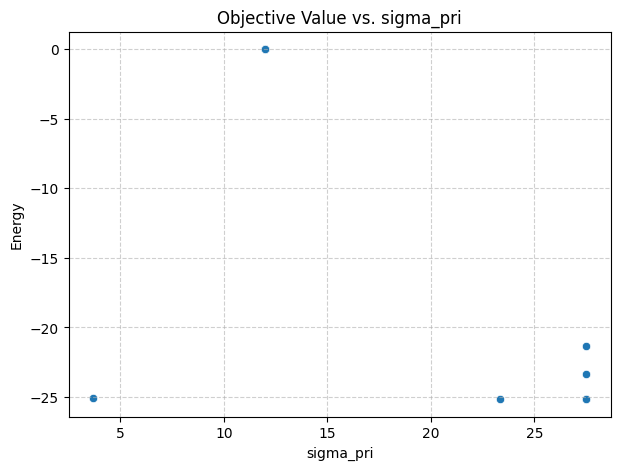

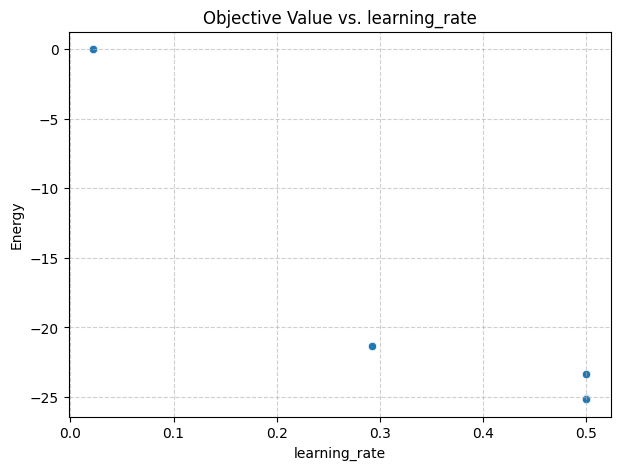

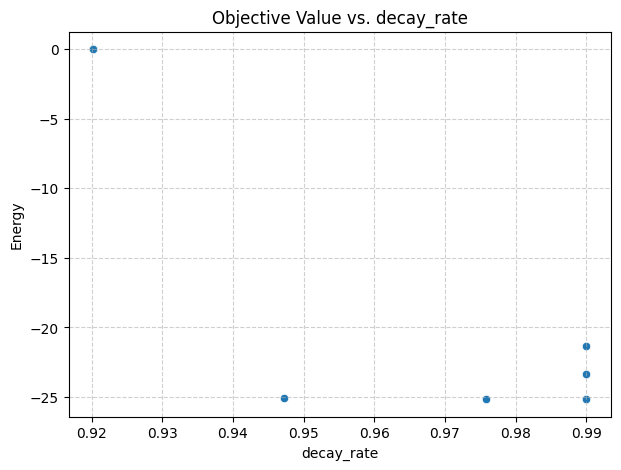

In [46]:
#Create scatter plots for numerical parameters vs. objective value
for col in numerical_cols:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=data, x=col, y='Energy')
    plt.title(f'Objective Value vs. {col}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# For categorical parameters, a boxplot or swarmplot is more effective
for col in categorical_cols:
    plt.figure(figsize=(7, 5))
    sns.swarmplot(data=data, x=col, y='Energy')
    plt.title(f'Objective Value vs. {col}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/

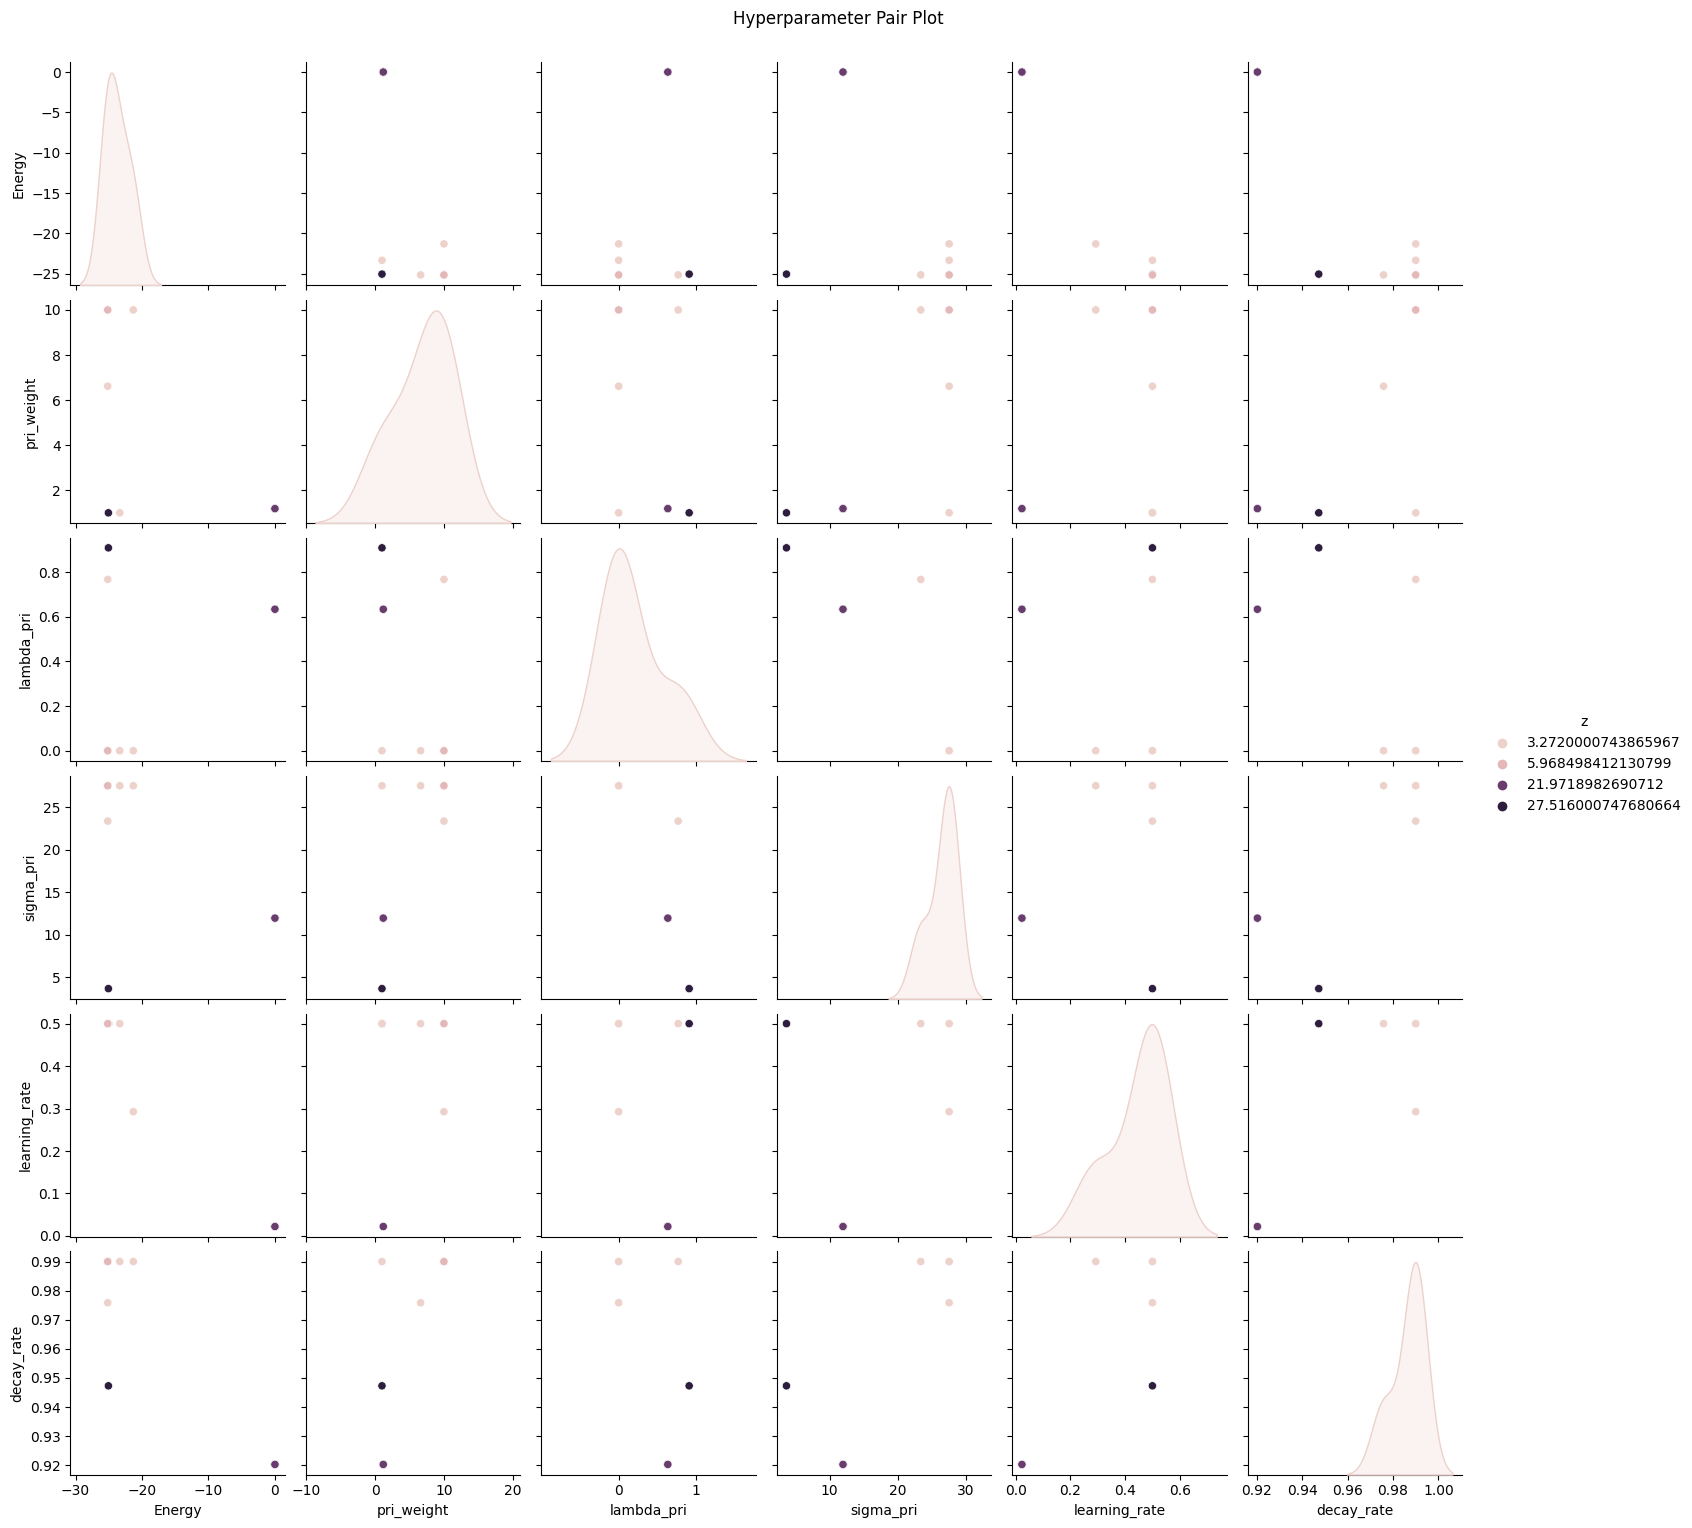

In [47]:
# The pairplot shows scatterplots for joint relationships and histograms for univariate distributions.
# We can color the points by a categorical variable if we have one.
# For this plot, it's often useful to include the objective_value as well.
pairplot_fig = sns.pairplot(data, hue='z' if 'z' in data.columns else None)
pairplot_fig.fig.suptitle("Hyperparameter Pair Plot", y=1.02) # y=1.02 is to adjust title position
plt.show()

In [48]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour
)

# Show the optimization history
plot_optimization_history(study)


In [49]:
# Show the parameter importances
plot_param_importances(study)

In [50]:
# Show a parallel coordinate plot
plot_parallel_coordinate(study)

In [51]:
# Show a contour plot for the most important parameters
# Optuna automatically picks the two most important ones
plot_contour(study)

# Entrenamiento y resultados

**Loop de entrenamiento con los hiperparametros optimizados**

In [52]:
# Get the best hyperparameters from the study
best_params = study.best_trial.params
print("\nBest Hyperparameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Set up the final simulation using these parameters
final_z = best_params['z'] #Altura optima inicial de los iones
#Hiperparametros de regularización
final_pri_weight = tf.constant(best_params['pri_weight'], dtype=tf.float32) #Peso PRI vs Fisica
final_lambda_pri = tf.constant(best_params['lambda_pri'], dtype=tf.float32) #Peso Entropia ion-ion vs cruzada
final_sigma_pri = tf.constant(best_params['sigma_pri'], dtype=tf.float32) # Ancho del kernel RBF
#Hiperparametros del entrenamiento
final_lr = best_params['learning_rate']
final_decay = best_params['decay_rate']

# Re-initialize the ion at the optimal starting height
final_initial_positions = build_ions(num_ni=1, z=final_z)
ion_final = tf.Variable(final_initial_positions, dtype=tf.float32)
ion_final_ = ion_final.numpy()
optimizer_final = tf.keras.optimizers.Adam(learning_rate=final_lr)

#Pintamos la posicion inicial de los iones con la altura final
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

# Loop de entrenamiento final
epochs = 300

starting_pos =ion_final_.copy()
loss_history = []#Para guardar y graficar la energía del sistema

early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(final_lr, decay_rate=final_decay, epoch=epoch)
    optimizer_final.learning_rate.assign(eta)
    
    with tf.GradientTape() as g:
        g.watch(ion_final)
        H_loss,ion_total_energies = get_training_loss(sample_atoms,sample_elements,ion_final,
                                                      final_pri_weight,final_lambda_pri,final_sigma_pri)
        loss_history.append(H_loss)
    grad_ = g.gradient(H_loss, ion_final)
    optimizer_final.apply_gradients(zip([grad_], [ion_final]))
    print(f'Loss: {H_loss.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    """if early_stopping.on_epoch_end(epoch, H_loss.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        break"""
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {H_loss.numpy():.4f} | LR: {optimizer_final.learning_rate.numpy():.4f}')
    ion_final_ =  ion_final.numpy()
    gradN = -10*eta*grad_.numpy()
    # For quiver, we need to create a 3D representation of the gradient
    # Assuming gradN is a 2D array (num_ions, 2)
    gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
    gradN_3D = gradN  # Copy x and y components from gradN
    if (epoch+1)%15==0:
    
    
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
        ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')
    
        
    
        ax.quiver(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                  color='g', length=1, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
    
        #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
        plt.show()



Best Hyperparameters Found:
  z: 3.2720000743865967
  pri_weight: 1.0
  lambda_pri: 0.0
  sigma_pri: 27.516000747680664
  learning_rate: 0.49999999999999994
  decay_rate: 0.99


TypeError: build_ions() got an unexpected keyword argument 'num_ni'

# Evaluacion de la energía final

In [ ]:
#Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
final_energy,_= calculate_final_system_energy(
    sample_atoms,  # Tensor con TODAS las posiciones de átomos de la superficie (Zn + O)
    sample_elements,   # Tensor con las etiquetas correspondientes
    ion_final
    )
    
# Pasa a numpy para reportes
system_energy = final_energy.numpy()

In [ ]:
num_ni=2
print(f'Atomos en la superficie: {num_atoms} - Iones a adsorber: {num_ni}')
print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(ion_total_energies):.5f} ev/atom") #Revisar
distance = ion_final_ - starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
print(f'Distancia viajada promedio (vectorial): {mean_vector}')
print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

In [ ]:
# --- Gráfica de la evolución de la pérdida ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida Total (Física + PRI)")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.grid(True)
plt.show()

In [ ]:
# --- Gráfica 3D de posiciones iniciales y finales ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Superficie
colors_map = {"Zn": "grey", "O": "blue"}
for atom_type in set(elements):
    idx = (elements == atom_type)
    ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2],
               color=colors_map.get(atom_type, "black"),
               label=f'Superficie ({atom_type})', s=80, alpha=0.6)

# Posiciones de los iones
ax.scatter(starting_pos[:, 0], starting_pos[:, 1], starting_pos[:, 2],
           color='orange', label='Iones (Inicial)', s=150, marker='x')
ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2],
           color='red', label='Iones (Final)', s=150, edgecolors='k')

# Flechas de trayectoria
for i in range(num_ni):
    ax.quiver(starting_pos[i, 0], starting_pos[i, 1], starting_pos[i, 2],
              gradN_3D[i, 0], gradN_3D[i, 1], gradN_3D[i, 2],
              color='green', arrow_length_ratio=0.3, alpha=0.7)

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Posiciones Iniciales y Finales de los Iones de Ni")
ax.legend()
plt.tight_layout()
plt.show()